### Ramblings

#### Background

After much trial and error with simpler approaches like clustering and metaphones, I'm resolving to use pretrained phonetic embeddings.\
This team https://github.com/rahulsrma26/phonetic-word-embedding published a pretrained set of embeddings for the `cmudict` english phonetic dictionary.\
A scan of their paper suggests their basic approach was:
- Encode phonemes into Arpabet articulatory features -- (using phoneme spellings from the `cmudict`)
- Compute a custom Jaccard similarity score for bigrams of phoneme features that weights terminating vowel phonemes more highly (e.g. "marrY")
- Chain these bigram similarities into word similarity sums
- Compute a similarity matrix $M$ by computing this simliarity across all pairs of words
- Use SGD to learn word embeddings $V$ by minimizing loss $||M - VV^\intercal||^2$

**ABOUT THE LOSS**:\
This is pretty neat. For a dictionary of $d$ words and an embedding space of $m$ dimensions, $M \in \reals^{d\times d}$ and $V \in \reals^{d\times m}$. Thus, $VV^\intercal$ is actually a ***factorization*** of $M$. It gives us $m$-dimensional representations of each word that *preserve* the similarities we defined and computed in $M$. Indeed, $V$ could be derived with matrix-factorization since $M$ is positive symmetric. The authors use SGD instead since $M$ is prohibitively large for factorization.\
It is important to note as well that because we are effectively learning a factorization of the similarity matrix, the choice of the similarity scores used to comprise the matrix is *the most crucial factor* in making these embeddings meaningful. Not the loss function, or the model used for SGD.

I think using these embeddings locks my into the words in `cmudict`. While they provide code for their SGD implementation, I don't think I can learn new word embeddings via fine-tuning because I would need to recompute a new similarity matrix $M$ that includes those new words....

#### Approach

The objective of this notebook is to expand the vocabulary of these pretrained embeddings to include the full set of alphanumeric lemmas in the `wordnet` corpus. High-level, we're going to train a simple NN (maybe small transformer, maybe small RNN) to learn the final phonetic embeddings in the pretrained dataset from input words. This will hopefully allow us to guess good embeddings for `wordnet` lemmas that aren't in the `cmudict` corpus.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.functional as F
import torch.nn as nn

import nltk
nltk.download('wordnet')
nltk.download('cmudict')
from nltk.corpus import wordnet as wn
from nltk.corpus import cmudict

# from google.colab import drive
# drive.mount('/content/drive')

vec_path = r"C:\Users\benak\Downloads\simvecs"

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\benak\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


## Data Preprocessing

In [2]:
max_lemma_len = 15

In [3]:
# read in words and pretrained embeddings from drive
texts = []
with open(vec_path, 'r') as file:
    for line in file.read().splitlines():
        texts.append(line)

mappings = [texts[i].split() for i in range(len(texts))]
mappings = [m for m in mappings if m[0].isalpha() and len(m[0]) <= max_lemma_len]  # drop non-alphanumeric words & embeddings

words = [list(mappings[i][0].lower()) for i in range(len(mappings))]
emb = np.array([mappings[i][1:] for i in range(len(mappings))]).astype(float)

del texts
del mappings

In [4]:
lemmas = [list(l.lower()) for l in wn.all_lemma_names() if l.isalpha() and len(l) <= max_lemma_len]

# numerically encode wn lemmas and cmudict words
import string
alph = string.ascii_lowercase
ctoi = {c:i+1 for i,c in enumerate(alph)}
itoc = {i+1:c for i,c in enumerate(alph)}

enc = lambda x: [ctoi[c] for c in x] + [0]*(max_lemma_len - len(x))  # right pad with 0
dec = lambda x: [itoc[i] for i in x if i != 0]

lemmas_enc = np.array([enc(l) for l in lemmas])
words_enc = np.array([enc(w) for w in words])

In [5]:
lemmas_enc.shape, words_enc.shape

((76559, 15), (116274, 15))

In [63]:
class MiniBatch:
    def __init__(self, x, y, batch_size):
        self.x = x if isinstance(x, torch.Tensor) else torch.tensor(x)
        self.y = y if isinstance(y, torch.Tensor) else torch.tensor(y, dtype=torch.float32)
        self.batch_size = batch_size

    def get_batch(self):
        idx = torch.randint(0, self.x.shape[0], (self.batch_size,), device=self.x.device)
        return self.x[idx], self.y[idx]

In [101]:
def train_epoch(model, X, Y, loss_fn, optimizer, batch_size, track_losses: bool = False):
    """Train for one epoch."""
    model.train()
    n_batches = X.shape[0] // batch_size
    total_loss = 0

    losses = []
    for _ in range(n_batches):
        xb, yb = MiniBatch(X, Y, batch_size).get_batch()
        
        optimizer.zero_grad()
        preds = model(xb)
        
        if isinstance(loss_fn, nn.CosineEmbeddingLoss):
            target = torch.ones(preds.shape[0], device=preds.device)
            loss = loss_fn(preds, yb, target)
        else:
            loss = loss_fn(preds, yb)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if track_losses: losses.append(loss.item())

    if track_losses:
        return total_loss / n_batches, losses
    else:
        return total_loss / n_batches


@torch.no_grad()  # Decorator ensures no gradients are computed
def eval_loss(model, X, Y, loss_fn, sample_frac=0.2):
    """
    Evaluate model loss on a random sample of data.
    """
    # Store and set evaluation mode
    was_training = model.training
    model.eval()
    
    try:
        n_samples = max(1, int(X.shape[0] * sample_frac))
        indices = torch.randperm(X.shape[0], device=X.device)[:n_samples]
        
        preds = model(X[indices])
        
        if isinstance(loss_fn, nn.CosineEmbeddingLoss):
            target = torch.ones(preds.shape[0], device=preds.device)
            loss = loss_fn(preds, Y[indices], target)
        else:
            loss = loss_fn(preds, Y[indices])
        
        return loss.item()
    
    finally:
        # Always restore training state, even if error occurs
        if was_training:
            model.train()

In [20]:
def wlookup(word):
    wenc = enc(word)
    idx = words_enc.tolist().index(wenc)
    return word, words_enc[idx], emb[idx]

def cosine_sim(a, b):
    if isinstance(a, torch.Tensor):
        a = a.cpu().detach().numpy()
    if isinstance(b, torch.Tensor):
        b = b.cpu().detach().numpy()
    a = a.reshape(-1, 1)
    b = b.reshape(-1, 1)
    return np.dot(a.T, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def mse(a, b):
    return np.mean((a - b)**2)

# MLP Model

First pass is basic MLP with pooling

In [120]:
# hyperparameters
n_emb = 50

In [121]:
def mean_pool(x, mask):
    """
    Mean pooling that ignores sequence padding
    Zero-out padded indices and weight by count of non-zero elements
    """
    return (x * mask).sum(dim=1) / mask.sum(dim=1)

class MLP(nn.Module):
    def __init__(
            self,
            vs: int = 27,
            n_emb: int = 64,
            exp: int = 4,
            n_layers: int = 2,
        ):
        super().__init__()
        self.char_emb = nn.Embedding(vs, n_emb)  # learnable character embedding

        self.ffwd = nn.Sequential(
            nn.Linear(n_emb, n_emb * exp),
            nn.GELU(approximate='tanh'),
            nn.LayerNorm(n_emb * exp),

            *[
                layer for _ in range(n_layers)
                for layer in (
                    nn.Linear(n_emb * exp, n_emb * exp),
                    nn.GELU(approximate='tanh')
                )
            ],

            nn.LayerNorm(n_emb * exp)
        )

        self.fc_out = nn.Linear(n_emb * exp, 50)  # 50 is dim of target embeddings

    def forward(self, x):
        # B: batch_size, T: max_lemma_len, C: n_emb, H: n_hidden
        mask = (x != 0).float().unsqueeze(-1)
        x = self.char_emb(x)    # [B, T, C]
        x = mean_pool(x, mask)  # [B, C]
        x = self.ffwd(x)        # [B, H]
        x = self.fc_out(x)      # [B, 50]
        return x


### MLP Training and Testing

In [123]:
model = MLP(n_emb = 64, exp = 3, n_layers = 2)
# print parameter count
print("n params: ", sum(p.numel() for p in model.parameters()))
model.float()  # set all params to floats

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# move model to cuda (now that CUDA_LAUNCH_BLOCKING is set)
if device == "cuda":
    print("moving model to cuda now...")
    model.to("cuda")

n params:  98738
moving model to cuda now...


In [125]:
# get train-test split
from sklearn.model_selection import train_test_split
Xt, Xv, Yt, Yv = train_test_split(words_enc, emb, test_size=0.2)
Xt, Xv = torch.tensor(Xt).to(device), torch.tensor(Xv).to(device)
Yt, Yv = torch.tensor(Yt, dtype=torch.float32).to(device), torch.tensor(Yv, dtype=torch.float32).to(device)

initial losses: train loss 1.0272, val loss 1.0269
epoch 1: train loss 0.3654, val loss 0.3378         | ETA: 0.34 min
epoch 2: train loss 0.3258, val loss 0.3237         | ETA: 0.34 min
epoch 3: train loss 0.3150, val loss 0.3170         | ETA: 0.32 min
epoch 4: train loss 0.3090, val loss 0.3150         | ETA: 0.30 min
epoch 5: train loss 0.3041, val loss 0.3140         | ETA: 0.27 min
epoch 6: train loss 0.3003, val loss 0.3104         | ETA: 0.24 min
epoch 7: train loss 0.2985, val loss 0.3094         | ETA: 0.22 min
epoch 8: train loss 0.2961, val loss 0.3094         | ETA: 0.19 min
epoch 9: train loss 0.2932, val loss 0.3063         | ETA: 0.16 min
epoch 10: train loss 0.2916, val loss 0.3060         | ETA: 0.13 min
epoch 11: train loss 0.2902, val loss 0.3057         | ETA: 0.10 min
epoch 12: train loss 0.2882, val loss 0.3069         | ETA: 0.08 min
epoch 13: train loss 0.2869, val loss 0.3044         | ETA: 0.05 min
epoch 14: train loss 0.2863, val loss 0.3032         | ETA: 0

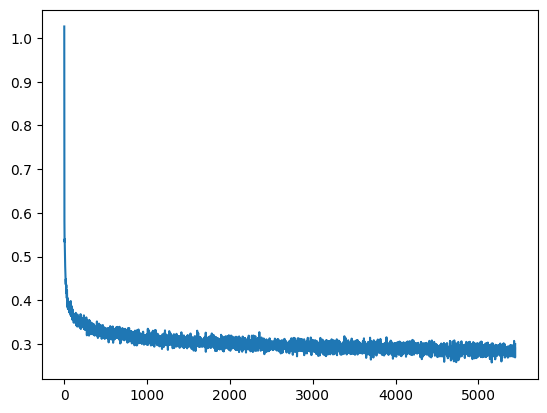

In [126]:
import time

# training
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

batch_size = 256
epochs = 15
epoch_iters = Xt.shape[0] // batch_size

mse_loss = nn.MSELoss(reduction='mean')
cos_loss = nn.CosineEmbeddingLoss(margin=0.0)
tloss, vloss = [], []

tloss.append(eval_loss(model, Xt, Yt, cos_loss, sample_frac=0.2))
vloss.append(eval_loss(model, Xv, Yv, cos_loss, sample_frac=0.5))
print(f"initial losses: train loss {tloss[-1]:.4f}, val loss {vloss[-1]:.4f}")

start = time.time()
training_losses = []
for epoch in range(epochs):
    epoch_loss, epoch_losses = train_epoch(model, Xt, Yt, cos_loss, optimizer, batch_size, track_losses=True)
    tloss.append(epoch_loss)
    training_losses.extend(epoch_losses)

    run_time = time.time() - start
    # tloss.append(eval_loss(tmod, Xt, Yt, cos_loss, sample_frac=0.2))
    vloss.append(eval_loss(model, Xv, Yv, cos_loss, sample_frac=0.5))

    print(
        f"epoch {epoch + 1}: train loss {tloss[-1]:.4f}, val loss {vloss[-1]:.4f} \
        | ETA: {(run_time / (epoch + 1)) * (epochs - epoch - 1) / 60:,.2f} min"
    )

print(f"total training time: {(time.time() - start) / 60:.2f} min")

plt.plot(training_losses);

# Transformer Model

This is an *encoder-only* transformer (e.g. BERT) that takes sequences of characters (words) as inputs and predicts their embeddings.

In [ ]:
import math
from dataclasses import dataclass
@dataclass(eq=False)  # eq=False enables child classes to still be hashable (long story)
class Config:
    block_size: int = 15
    n_emb: int = 64
    n_heads: int = 2
    head_size: int = n_emb // n_heads
    n_blocks: int = 2
    dropout: float = 0.2
    exp: int = 1
    pool: str = 'cls'
    mask_attn: bool = True


class AttentionLayer(nn.Module):
    def __init__(self, config: Config = None, **kwargs):
        super().__init__()
        self.config = Config(**kwargs) if config is None else config

        # ensure that we can evenly split the embedded input across the number of heads
        assert config.n_emb % config.n_head == 0, "Embedding Space not evenly divisible amongst attention heads"

        self.attn = nn.Linear(config.n_emb, 3 * config.n_emb, bias=False)  # for query, key, value -- split into K, Q, V during forward
        self.proj = nn.Linear(config.n_emb, config.n_emb)      # "projection" layer

        self.dropout = nn.Dropout(self.config.dropout)
        

    def forward(self, x, attn_mask=None):
        B, T, C = x.shape

        qkv = self.attn(x)  # (B, T, 3 * C)

        q, k, v = qkv.split(C, dim=2)  # split into query, key, value -- each (B, T, C)

        # each is (B, nh, T, hs) where nh:=n_head and hs:=head_size -- this effectively creates multiple attention heads
        q = q.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)
        k = k.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)
        v = v.view(B, T, self.config.n_head, C // self.config.n_head).transpose(1, 2)  

        weights = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))     # QK attention with standardization -- (B, nh, T, T)

        # apply attention mask (if provided)
        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(1).repeat(1, 1, 1, T)  # (B, 1, T, T)
            weights = weights.masked_fill(attn_mask == 0, float('-inf'))

        weights = nn.Softmax(dim=-1)(weights)

        v = self.value(x)
        out = (weights @ v).transpose(1, 2).contiguous().view(B, T, C)
        out = self.dropout(self.proj(out))

        return out


class MultiHead(nn.Module):
    def __init__(self, config: Config = None, **kwargs):
        super().__init__()
        self.config = Config(**kwargs) if config is None else config

        self.heads = nn.ModuleList([
            Head(config=self.config, **kwargs) for h in range(self.config.n_heads)
        ])
        self.proj = nn.Linear(self.config.head_size * self.config.n_heads, self.config.n_emb)
        self.dropout = nn.Dropout(self.config.dropout)

    def forward(self, x, attn_mask=None):
        out = torch.cat([h(x, attn_mask) for h in self.heads], dim=-1)  # feed forward through heads and concatenate output
        out = self.dropout(self.proj(out))                   # pass output through linear layer and apply dropout
        return out


class FeedForward(nn.Module):
    def __init__(self, config: Config = None, **kwargs):
        super().__init__()
        self.config = Config(**kwargs) if config is None else config

        self.net = nn.Sequential(
            nn.Linear(self.config.n_emb, self.config.exp * self.config.n_emb),
            nn.GELU(approximate='tanh'),
            nn.Linear(self.config.exp * self.config.n_emb, self.config.n_emb),
            nn.Dropout(self.config.dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, config: Config = None, **kwargs):
        super().__init__()
        self.config = Config(**kwargs) if config is None else config

        self.sa = MultiHead(config=config, **kwargs)     # self-attention stack
        self.ffwd = FeedForward(config=config, **kwargs) # feed-forward layer
        self.ln1 = nn.LayerNorm(self.config.n_emb)       # layer normalization for self-attention stack
        self.ln2 = nn.LayerNorm(self.config.n_emb)       # layer normalization for feed forward

    def forward(self, x, attn_mask=None):
        x = x + self.sa(self.ln1(x), attn_mask)     # residual self-attention stack connection
        x = x + self.ffwd(self.ln2(x))              # residual feed-forward connection
        return x


class TransformerModel(nn.Module):
    def __init__(self, config: Config = None, **kwargs):
        super().__init__()
        self.config = Config(**kwargs) if config is None else config

        if 'cls' in self.config.pool.lower():
            self.config.block_size += 1  # update for cls token
            self.cls_token = nn.Parameter(torch.randn(1, 1, self.config.n_emb))

        self.wte = nn.Embedding(27, self.config.n_emb)
        self.wpe = nn.Embedding(self.config.block_size, self.config.n_emb)
        self.blocks = nn.Sequential(*[
            Block(config=config, **kwargs) for b in range(self.config.n_blocks)
        ])
        self.ln_f = nn.LayerNorm(self.config.n_emb)
        self.lm_head = nn.Linear(self.config.n_emb, self.config.n_emb)

        # mlp projection layer
        self.projection = nn.Sequential(
            nn.Linear(self.config.n_emb, self.config.n_emb),
            nn.GELU(approximate='tanh'),
            nn.Dropout(self.config.dropout),
            nn.Linear(self.config.n_emb, 50)
        )

    def forward(self, input):
        B, T = input.shape

        mask = (input != 0).float().unsqueeze(-1)
        attn_mask = None

        # idx and targets are both (B, T) tensor of integers                    dimension tracking:
        tok_emb = self.wte(input)                                                  # (B,T,C)
        if self.config.pool.lower() == 'cls':
            tok_emb = torch.cat((self.cls_token.repeat(B, 1, 1), tok_emb), dim=1)  # (B,T+1,C) prepend class embedding

            if self.config.mask_attn:
                # add masking for attention -- mask padding tokens and ensure cls token is NOT masked
                cls_mask = torch.ones(B, 1, dtype=torch.float, device=input.device)
                attn_mask = torch.cat((cls_mask, mask.squeeze(-1)), dim=1)  # (B, T+1)

        pos_emb = self.wpe(torch.arange(tok_emb.shape[1], device=input.device))    # (T+1,C)
        x = tok_emb + pos_emb                                                      # (B,T+1,C)
        for block in self.blocks:
            x = block(x, attn_mask)                                                # (B,T+1,C)
        x = self.ln_f(x)                                                           # (B,T+1,C)
        pre_pool = self.lm_head(x)                                                 # (B,T+1,C)

        if 'mean' in self.config.pool.lower():
            pre_pool = mean_pool(pre_pool, mask)  # [B, C]
        elif 'cls' in self.config.pool.lower():
            pre_pool = pre_pool[:, 0, :]  # [B, C]

        preds = self.projection(pre_pool)

        return preds

In [154]:
tmod = TransformerModel(n_emb=64, exp=4, n_heads=2, n_blocks=2, dropout=0.2)

# print parameter count
print(f"n params: {sum(p.numel() for p in tmod.parameters()):,.0f}")
tmod.float();  # set all params to floats

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# move model to cuda (now that CUDA_LAUNCH_BLOCKING is set)
if device == "cuda":
    print("moving model to cuda now...")
    tmod.to("cuda")

    params_devices = {p.device for p in tmod.parameters()}
    buffers_devices = {b.device for b in tmod.buffers()}
    print("model param devices:", params_devices)
    print("model buffer devices:", buffers_devices)

    # run one tiny forward to trigger any kernel asserts immediately
    dummy = torch.zeros(1, 1, dtype=torch.long, device="cuda")  # id 0 is safe
    with torch.no_grad():
        try:
            out = tmod(dummy)    # if there's a kernel assert it will raise here with a real trace
            print("single forward succeeded; out shape:", out.shape)
        except Exception as e:
            print("forward on cuda failed with:", repr(e))
            raise

n params: 114,098
moving model to cuda now...
model param devices: {device(type='cuda', index=0)}
model buffer devices: set()
single forward succeeded; out shape: torch.Size([1, 50])


### Transformer Training and Testing

In [155]:
# get train-test split
from sklearn.model_selection import train_test_split
Xt, Xv, Yt, Yv = train_test_split(words_enc, emb, test_size=0.2)
Xt, Xv = torch.tensor(Xt).to(device), torch.tensor(Xv).to(device)
Yt, Yv = torch.tensor(Yt, dtype=torch.float32).to(device), torch.tensor(Yv, dtype=torch.float32).to(device)

initial losses: train loss 0.9826, val loss 0.9845
epoch 1: train loss 0.4199, val loss 0.2669         | ETA: 1.79 min
epoch 2: train loss 0.2927, val loss 0.2374         | ETA: 1.68 min
epoch 3: train loss 0.2764, val loss 0.2211         | ETA: 1.50 min
epoch 4: train loss 0.2643, val loss 0.2053         | ETA: 1.35 min
epoch 5: train loss 0.2561, val loss 0.1978         | ETA: 1.27 min
epoch 6: train loss 0.2500, val loss 0.1908         | ETA: 1.19 min
epoch 7: train loss 0.2461, val loss 0.1856         | ETA: 1.10 min
epoch 8: train loss 0.2413, val loss 0.1839         | ETA: 1.00 min
epoch 9: train loss 0.2380, val loss 0.1760         | ETA: 0.90 min
epoch 10: train loss 0.2353, val loss 0.1741         | ETA: 0.83 min
epoch 11: train loss 0.2337, val loss 0.1667         | ETA: 0.75 min
epoch 12: train loss 0.2319, val loss 0.1682         | ETA: 0.66 min
epoch 13: train loss 0.2302, val loss 0.1636         | ETA: 0.58 min
epoch 14: train loss 0.2282, val loss 0.1649         | ETA: 0

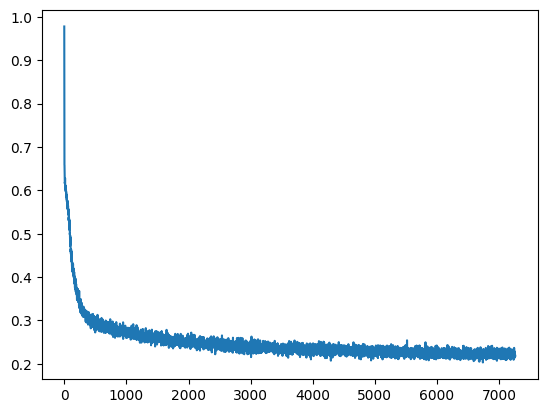

In [156]:
import time

# training
optimizer = torch.optim.AdamW(tmod.parameters(), lr=0.01)

batch_size = 256
epochs = 20
epoch_iters = Xt.shape[0] // batch_size

mse_loss = nn.MSELoss(reduction='mean')
cos_loss = nn.CosineEmbeddingLoss(margin=0.0)
tloss, vloss = [], []

tloss.append(eval_loss(tmod, Xt, Yt, cos_loss, sample_frac=0.2))
vloss.append(eval_loss(tmod, Xv, Yv, cos_loss, sample_frac=0.5))
print(f"initial losses: train loss {tloss[-1]:.4f}, val loss {vloss[-1]:.4f}")

start = time.time()
training_losses = []
for epoch in range(epochs):
    epoch_loss, epoch_losses = train_epoch(tmod, Xt, Yt, cos_loss, optimizer, batch_size, track_losses=True)
    tloss.append(epoch_loss)
    training_losses.extend(epoch_losses)

    run_time = time.time() - start
    # tloss.append(eval_loss(tmod, Xt, Yt, cos_loss, sample_frac=0.2))
    vloss.append(eval_loss(tmod, Xv, Yv, cos_loss, sample_frac=0.5))

    print(
        f"epoch {epoch + 1}: train loss {tloss[-1]:.4f}, val loss {vloss[-1]:.4f} \
        | ETA: {(run_time / (epoch + 1)) * (epochs - epoch - 1) / 60:,.2f} min"
    )

print(f"total training time: {(time.time() - start) / 60:.2f} min")

plt.plot(training_losses);

In [94]:
def dlword(word):
    return torch.tensor(wlookup(word)[1], device=device).unsqueeze(0)

In [157]:
tmod.eval()
cosine_sim(tmod(dlword('tough')), tmod(dlword('though')))

array([[0.43779698]], dtype=float32)

In [117]:
cosine_sim(wlookup('though')[2], wlookup('tough')[2])

array([[0.05044832]])

In [164]:
cosine_sim(tmod(dlword('though')), wlookup('though')[2])

array([[0.12432447]])

In [165]:
tmod.eval()
cosine_sim(tmod(dlword('motion')), wlookup('ocean')[2]), cosine_sim(wlookup('motion')[2], wlookup('ocean')[2])

(array([[0.65731746]]), array([[0.77937518]]))

In [166]:
cosine_sim(tmod(dlword('motion')), wlookup('motion')[2]), cosine_sim(tmod(dlword('ocean')), wlookup('ocean')[2])

(array([[0.89474297]]), array([[0.84438094]]))

In [176]:
cosine_sim(tmod(dlword('orange')), wlookup('orange')[2])

array([[0.57381988]])